<a href="https://colab.research.google.com/github/jonahlyn/colab/blob/master/MRCNN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Vehicles in a Parking Lot with MRCNN



## Dependencies

In [0]:
import os
import requests
from pathlib import Path
import numpy as np
import cv2

import datetime as dt
import time as tm

%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
print("OpenCV version: {}".format(cv2.__version__))

OpenCV version: 3.4.3


In [0]:
!pip install -q mrcnn

    100% |████████████████████████████████| 61kB 2.4MB/s 


In [0]:
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [0]:
!apt-get -qq install tesseract-ocr -y 
!apt-get -qq install libtesseract-dev

Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_4.00~git24-0e00fe6-1.2_all.deb ...
Unpacking tesseract-ocr-eng (4.00~git24-0e00fe6-1.2) ...
Selecting previously unselected package tesseract-ocr-osd.
Preparing to unpack .../tesseract-ocr-osd_4.00~git24-0e00fe6-1.2_all.deb ...
Unpacking tesseract-ocr-osd (4.00~git24-0e00fe6-1.2) ...
Selecting previously unselected package tesseract-ocr.
Preparing to unpack .../tesseract-ocr_4.00~git2288-10f4998a-2_amd64.deb ...
Unpacking tesseract-ocr (4.00~git2288-10f4998a-2) ...
Setting up tesseract-ocr-osd (4.00~git24-0e00fe6-1.2) ...
Setting up tesseract-ocr-eng (4.00~git24-0e00fe6-1.2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up tesseract-ocr (4.00~git2288-10f4998a-2) ...
Selecting previously unselected package libleptonica-dev.
(Reading database ... 131341 files and directories currently installed.)


In [0]:
!pip install -q pytesseract

    100% |████████████████████████████████| 174kB 7.1MB/s 


In [0]:
import cv2
import sys
import pytesseract

## Data Collection

In [0]:
cam1_image = "http://www.flyrdm.com/images/uploads/cameras/NorthEast000M.jpg"
cam2_image = "http://www.flyrdm.com/images/uploads/cameras/SouthWest000M.jpg"
r = requests.get(cam1_image)

if r.status_code == 200:
  print("Download successful")
  print("File size: {}".format(r.headers['Content-Length']))
  print("Content type: {}".format(r.headers['Content-Type']))

Download successful
File size: 315850
Content type: image/jpeg


In [0]:
nparr = np.frombuffer(r.content, np.uint8)
imgnp = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
imgrgb = cv2.cvtColor(imgnp, cv2.COLOR_BGR2RGB)


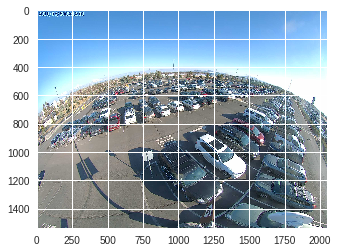

In [0]:
plt.imshow(imgrgb)
plt.show()

In [0]:
output_img = imgrgb.copy()

## MaskRCNN

https://medium.com/@ageitgey/snagging-parking-spaces-with-mask-r-cnn-and-python-955f2231c400

In [0]:
# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6

In [0]:
# Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

In [0]:
CURRENT_DIR = Path(".")
MODEL_DIR = os.path.join(CURRENT_DIR, "logs")
MODEL_PATH = os.path.join(CURRENT_DIR, "mask.rcnn.coco.h5")

if not os.path.exists(MODEL_PATH):
  mrcnn.utils.download_trained_weights(MODEL_PATH)

... done downloading pretrained model!


In [0]:
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())
model.load_weights(MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
results = model.detect([imgrgb], verbose=0)

In [0]:
result = results[0]
car_boxes = get_car_boxes(result['rois'], result['class_ids'])

for box in car_boxes:
  y1, x1, y2, x2 = box
  cv2.rectangle(output_img, (x1, y1), (x2, y2), (0,255,0), 2)

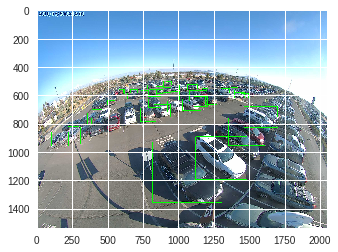

In [0]:
plt.imshow(output_img)
plt.show()

In [0]:
print("{} vehicles detected in the image".format(len(car_boxes)))

48 vehicles detected in the image


## Tesseract

https://www.learnopencv.com/deep-learning-based-text-recognition-ocr-using-tesseract-and-opencv/

Page segmentation modes:
- 0    Orientation and script detection (OSD) only.
- 1    Automatic page segmentation with OSD.
- 2    Automatic page segmentation, but no OSD, or OCR.
- 3    Fully automatic page segmentation, but no OSD. (Default)
- 4    Assume a single column of text of variable sizes.
- 5    Assume a single uniform block of vertically aligned text.
- 6    Assume a single uniform block of text.
- 7    Treat the image as a single text line.
- 8    Treat the image as a single word.
- 9    Treat the image as a single word in a circle.
- 10    Treat the image as a single character.

In [0]:
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
pytesseract.get_tesseract_version()

LooseVersion ('4.0.0-beta.1')

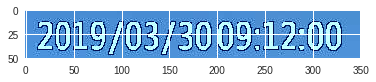

In [0]:
img_timestamp_area = output_img[0:50, 0:350]
plt.imshow(img_timestamp_area)
plt.show()

In [0]:
# Define config parameters.
# '-l eng'  for using the English language
# '--oem 1' for using Neural nets LSTM OCR Engine
# '--psm 6' for single uniform block of text for Page Segmentation Mode

config = ('-l eng --oem 1 --psm 6')
img_timestamp = pytesseract.image_to_string(img_timestamp_area, config=config)
print(img_timestamp)

DONO KOS VEO


In [0]:
try:
  d = dt.datetime.strptime(img_timestamp, '%Y/%m/%d%H:%M:%S')
except ValueError:
  
  try:
    d = dt.datetime.strptime(img_timestamp, '%Y/%m/%d %H:%M:%S')
  except ValueError:
    d = dt.datetime.fromtimestamp(tm.time())
  
d.strftime('%Y%m%d%H%M%S')

'20190330162018'

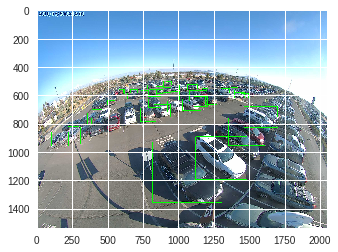

In [0]:
plt.imshow(output_img)
plt.show()

## Save the Output

In [0]:
output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_{}.png".format(d.strftime('%Y%m%d%H%M%S')), output_img)

True